In [1]:
## import the necessary pytorch packages
import numpy as np
from time import time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
## transform the data to tensor + normalize
## note that this does not flatten the image. Need to do that later.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

## set up training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

## set up validation data
valset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
valloader = DataLoader(valset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [3]:
## define the model
input_size = 784 # = flattened 28x28 images
hidden_sizes = [256, 128, 64]
output_size = 10
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                        nn.ReLU(), 
                        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[2], output_size),
                        nn.LogSoftmax(dim=1))

## define the loss function
criterion = nn.NLLLoss()

In [5]:
# main training loop
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
start_time = time()
epochs = 15
train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # flatten the images
        images = images.view(images.shape[0], -1)
        # clear the gradients
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # backpropagation
        loss.backward()
        # update the weights
        optimizer.step()
        # update the running loss
        running_loss += loss.item()
    else:
        # calculate the validation loss
        val_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in valloader:
                images = images.view(images.shape[0], -1)
                output = model(images)
                val_loss += criterion(output, labels)
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss/len(valloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))

Epoch: 1/15..  Training Loss: 0.034..  Validation Loss: 0.079..  Validation Accuracy: 0.976
Epoch: 2/15..  Training Loss: 0.032..  Validation Loss: 0.074..  Validation Accuracy: 0.977
Epoch: 3/15..  Training Loss: 0.028..  Validation Loss: 0.075..  Validation Accuracy: 0.978
Epoch: 4/15..  Training Loss: 0.026..  Validation Loss: 0.073..  Validation Accuracy: 0.978
Epoch: 5/15..  Training Loss: 0.023..  Validation Loss: 0.076..  Validation Accuracy: 0.977
Epoch: 6/15..  Training Loss: 0.023..  Validation Loss: 0.083..  Validation Accuracy: 0.976
Epoch: 7/15..  Training Loss: 0.018..  Validation Loss: 0.073..  Validation Accuracy: 0.980
Epoch: 8/15..  Training Loss: 0.016..  Validation Loss: 0.069..  Validation Accuracy: 0.980
Epoch: 9/15..  Training Loss: 0.015..  Validation Loss: 0.078..  Validation Accuracy: 0.979
Epoch: 10/15..  Training Loss: 0.013..  Validation Loss: 0.078..  Validation Accuracy: 0.979
Epoch: 11/15..  Training Loss: 0.012..  Validation Loss: 0.073..  Validation Ac

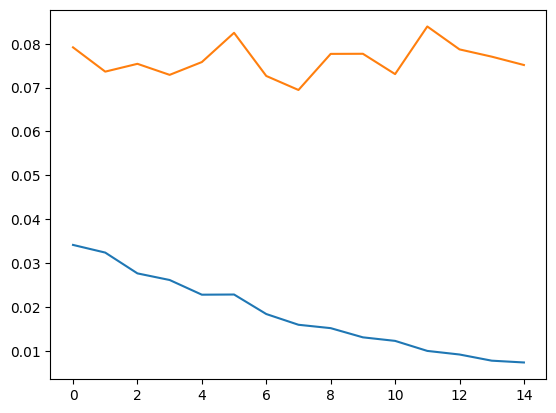

In [6]:
## plot training curves
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')